<a href="https://colab.research.google.com/github/jli184/UM_WolverinePathways_2023/blob/main/pathways2023_SN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install alerce

In [ ]:
!pip install astroquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 21.3 MB/s eta 0:00:00


In [ ]:
from alerce.core import Alerce
alerce = Alerce()

import numpy as np
import matplotlib.pyplot as plt
from astroquery.ipac.ned import Ned
from astroquery.ipac.irsa.irsa_dust import IrsaDust

import astropy.units as u
from astropy import coordinates
#from astropy.time import Time
#from astropy.table import Table, Column
from astropy.coordinates import Distance
from astropy.cosmology import WMAP7
from scipy.constants import c
from scipy.optimize import curve_fit

# Estimating Hubble constant using supernova light curves

## Step 1. Get a list of supernova from ZTF/ALeRCE

ps. I'm using ChatGPT to autogenerate all the comments for this notebook, just for fun!

In [ ]:
# Define a dictionary with various parameters for the query
params = {
    "classifier": "lc_classifier",   # Specifies the type of classifier to use
    "format": "pandas",              # The desired format of the output (in this case, pandas DataFrame)
    "class_name": 'SNIa',            # The name of the class (type of astronomical object) to query for
    "probability": 0.5,              # The minimum probability threshold for the query
    "ndet": [100, 1000],             # A list representing the range of number of detections to filter by
    "order_by": 'ndet',              # The parameter by which the results will be ordered
    "order_mode": "DESC"             # The order in which the results will be sorted (DESC: descending order)
}

# Perform a query to the 'alerce' service using the specified parameters
objects = alerce.query_objects(**params)

# The variable 'objects' now contains the results of the query in the specified pandas DataFrame format
# You can use this DataFrame to further analyze and manipulate the data.
objects

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF20abvtozi,172,1515,59083.476030,59189.221250,False,False,174,-0.025095,NaN,...,59189.221250,105.745220,51.623669,33.748571,0.000054,0.000030,SNIa,lc_classifier,0.602000,corr_bulk_0.0.1
1,ZTF20aayxldg,398,2232,58978.310174,59072.200625,False,False,169,0.076988,NaN,...,59072.199688,93.889514,248.072242,50.190518,0.000078,0.000039,SNIa,lc_classifier,0.574000,corr_bulk_0.0.1
2,ZTF20aaavvlv,196,885,58849.424769,58912.215648,False,False,160,-0.244247,NaN,...,58912.215648,62.789988,139.623754,28.141620,0.000044,0.000039,SNIa,lc_classifier,0.586000,corr_bulk_0.0.1
3,ZTF22aasxakz,135,2276,59770.500000,59867.250000,False,False,152,-0.045295,NaN,...,59867.166620,96.709618,305.798481,8.185057,0.000033,0.000030,SNIa,lc_classifier,0.516000,1.1.6
4,ZTF20abojcmt,151,2277,59052.479433,59091.472234,False,False,150,-0.007723,NaN,...,59091.472234,38.992801,7.491506,41.597723,0.000073,0.000046,SNIa,lc_classifier,0.572544,corr_bulk_0.0.1
5,ZTF20abeljuj,155,3840,59011.305752,59099.191748,False,False,150,-0.097193,NaN,...,59099.191748,87.885995,278.875436,36.592326,0.000033,0.000038,SNIa,lc_classifier,0.572000,corr_bulk_0.0.1
6,ZTF20aboquuv,147,858,59054.471181,59144.246806,False,False,145,-0.001860,NaN,...,59144.246806,89.775625,3.773355,43.343259,0.000028,0.000026,SNIa,lc_classifier,0.550000,corr_bulk_0.0.1
7,ZTF21aaunadg,198,4443,59314.467940,59414.387662,False,False,141,-0.022900,NaN,...,59414.387662,98.914699,278.927122,51.122183,0.000068,0.000027,SNIa,lc_classifier,0.504000,correction_0.0.1
8,ZTF20abbozif,168,3621,58992.353229,59053.305694,True,False,140,-0.088173,0.137247,...,59053.304768,60.950613,267.155589,60.706611,0.000097,0.000032,SNIa,lc_classifier,0.524160,corr_bulk_0.0.1
9,ZTF19abinjcy,314,1829,58688.327616,58734.272130,False,False,140,-0.009277,0.057051,...,58734.271620,45.944005,272.772595,69.592607,0.000086,0.000030,SNIa,lc_classifier,0.511872,corr_bulk_0.0.1


In [ ]:
def plot_diffLC(oid):

    # Query detections and non-detections for the given 'oid' from the 'alerce' service in pandas DataFrame format
    detections = alerce.query_detections(oid, format="pandas")
    non_detections = alerce.query_non_detections(oid, format="pandas")

    # Set up the plot with a specific size
    plt.subplots(figsize=(10, 5))

    # Dictionary to map filter IDs (fid) to labels, colors, and markers
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}

    # Loop through the filter IDs (fid), in this case [1, 2] representing 'g' and 'r' filters
    for fid in [1, 2]:

        # Plot detections if available for the current filter
        mask = detections.fid == fid
        if np.sum(mask) > 0:
            # Use error bars to plot the magnitude and its uncertainty (error) for detections
            plt.errorbar(detections[mask].mjd, detections[mask].magpsf,
                         yerr=detections[mask].sigmapsf, c=colors[fid], fmt=markers[fid], label=labels[fid],
                         markersize=3)

            # Store the data for 'g' and 'r' bands for further analysis (LC: Light Curve)
            if fid == 1:
                LC_g = np.array([detections[mask].mjd, detections[mask].magpsf, detections[mask].sigmapsf])
            if fid == 2:
                LC_r = np.array([detections[mask].mjd, detections[mask].magpsf, detections[mask].sigmapsf])

        # Plot non-detections if available for the current filter
        mask = (non_detections.fid == fid) & (non_detections.diffmaglim > -900)
        if np.sum(mask) > 0:
            # Plot non-detections with downward triangles representing the limiting magnitude
            plt.plot(non_detections[mask].mjd, non_detections[mask].diffmaglim, c=colors[fid], alpha=0.5,
                     marker='v', label="lim.mag. %s" % labels[fid], linestyle='', markersize=3)

    # Set plot title and axis labels
    plt.title(oid)
    plt.gca().invert_yaxis()  # Invert y-axis to represent brighter magnitudes at the top
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('MJD', fontsize=14)
    plt.ylabel('Difference Magnitude', fontsize=14)

    # Add legend to the plot
    plt.legend(fontsize=12)

    # Return the data for 'g' and 'r' bands as numpy arrays (LC_g and LC_r) for further use if needed
    return LC_g, LC_r


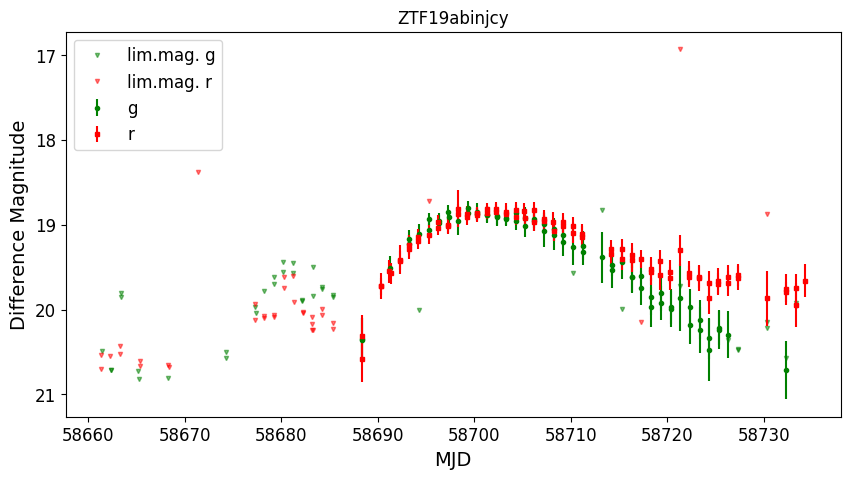

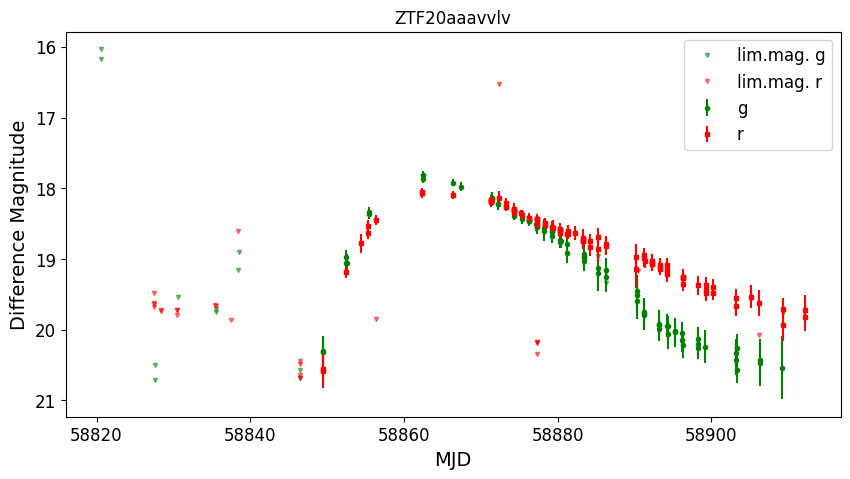

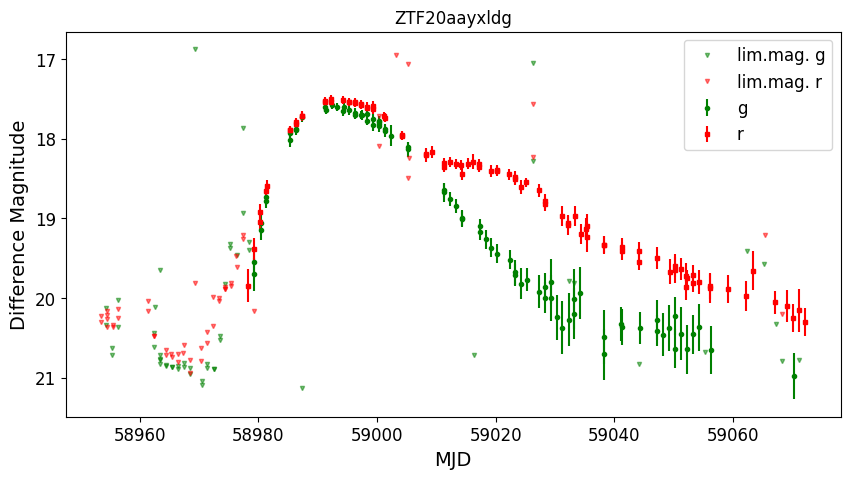

In [ ]:
# Loop through the unique object IDs ('oid') obtained from the 'objects' DataFrame, considering the first three elements
for oid in np.unique(objects['oid'])[:3]:

    # Call the 'plot_diffLC' function to generate plots for the object with the current 'oid'
    # The function will plot the light curves (LC) for the 'g' and 'r' filters
    # The resulting 'LC_g' and 'LC_r' are overwritten with each loop, but they can be stored separately for further analysis if needed
    LC_g, LC_r = plot_diffLC(oid)


## Step 2. Correct for extinction

In [ ]:
def get_ext(oid):

    # Query 'alerce' service to get information about the object with the given 'oid'
    objects = alerce.query_objects(oid=oid, page_size=len(oid))

    # Extract the mean right ascension (ra) and declination (dec) from the queried object data
    # Create a SkyCoord object to represent the celestial coordinates (ra, dec) in the FK5 coordinate frame
    coord = coordinates.SkyCoord(ra=objects.meanra, dec=objects.meandec, unit=(u.deg, u.deg), frame='fk5')

    # Initialize arrays to store extinction values for the 'g' and 'r' filters
    ext_g = np.zeros(len(coord))
    ext_r = np.zeros(len(coord))

    # Loop through each coordinate (ic: index, c: SkyCoord object) and query for dust extinction values
    for ic, c in enumerate(coord):
        # Query the IRSA Dust Service to obtain extinction values for the given coordinate
        table = IrsaDust.get_extinction_table(c)

        # Extract the extinction values for the 'g' and 'r' filters from the query result
        ext_g[ic] = table[table["Filter_name"] == "SDSS g"]["A_SFD"]
        ext_r[ic] = table[table["Filter_name"] == "SDSS r"]["A_SFD"]

    # Return the arrays containing extinction values for the 'g' and 'r' filters
    return ext_g, ext_r;

In [ ]:
# Define a dictionary with various parameters for the query
params = {
    "classifier": "lc_classifier",   # Specifies the type of classifier to use
    "format": "pandas",              # The desired format of the output (in this case, pandas DataFrame)
    "class_name": 'SNIa',            # The name of the class (type of astronomical object) to query for
    "probability": 0.5,              # The minimum probability threshold for the query
    "ndet": [100, 1000],             # A list representing the range of number of detections to filter by
    "order_by": 'ndet',              # The parameter by which the results will be ordered
    "order_mode": "DESC"             # The order in which the results will be sorted (DESC: descending order)
}

# Perform a query to the 'alerce' service using the specified parameters
# The query will return objects that match the given criteria as a pandas DataFrame
objects = alerce.query_objects(**params)

# Extract the 'oid' (object ID) column from the 'objects' DataFrame and pass it to the 'get_ext' function
# 'get_ext' will query the IRSA Dust Service to obtain dust extinction values for the 'g' and 'r' filters
# The result will be stored in the 'ext_g' and 'ext_r' arrays
ext_g, ext_r = get_ext(objects['oid'])

objects

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF20abvtozi,172,1515,59083.476030,59189.221250,False,False,174,-0.025095,NaN,...,59189.221250,105.745220,51.623669,33.748571,0.000054,0.000030,SNIa,lc_classifier,0.602000,corr_bulk_0.0.1
1,ZTF20aayxldg,398,2232,58978.310174,59072.200625,False,False,169,0.076988,NaN,...,59072.199688,93.889514,248.072242,50.190518,0.000078,0.000039,SNIa,lc_classifier,0.574000,corr_bulk_0.0.1
2,ZTF20aaavvlv,196,885,58849.424769,58912.215648,False,False,160,-0.244247,NaN,...,58912.215648,62.789988,139.623754,28.141620,0.000044,0.000039,SNIa,lc_classifier,0.586000,corr_bulk_0.0.1
3,ZTF22aasxakz,135,2276,59770.500000,59867.250000,False,False,152,-0.045295,NaN,...,59867.166620,96.709618,305.798481,8.185057,0.000033,0.000030,SNIa,lc_classifier,0.516000,1.1.6
4,ZTF20abojcmt,151,2277,59052.479433,59091.472234,False,False,150,-0.007723,NaN,...,59091.472234,38.992801,7.491506,41.597723,0.000073,0.000046,SNIa,lc_classifier,0.572544,corr_bulk_0.0.1
5,ZTF20abeljuj,155,3840,59011.305752,59099.191748,False,False,150,-0.097193,NaN,...,59099.191748,87.885995,278.875436,36.592326,0.000033,0.000038,SNIa,lc_classifier,0.572000,corr_bulk_0.0.1
6,ZTF20aboquuv,147,858,59054.471181,59144.246806,False,False,145,-0.001860,NaN,...,59144.246806,89.775625,3.773355,43.343259,0.000028,0.000026,SNIa,lc_classifier,0.550000,corr_bulk_0.0.1
7,ZTF21aaunadg,198,4443,59314.467940,59414.387662,False,False,141,-0.022900,NaN,...,59414.387662,98.914699,278.927122,51.122183,0.000068,0.000027,SNIa,lc_classifier,0.504000,correction_0.0.1
8,ZTF20abbozif,168,3621,58992.353229,59053.305694,True,False,140,-0.088173,0.137247,...,59053.304768,60.950613,267.155589,60.706611,0.000097,0.000032,SNIa,lc_classifier,0.524160,corr_bulk_0.0.1
9,ZTF19abinjcy,314,1829,58688.327616,58734.272130,False,False,140,-0.009277,0.057051,...,58734.271620,45.944005,272.772595,69.592607,0.000086,0.000030,SNIa,lc_classifier,0.511872,corr_bulk_0.0.1


In [ ]:
def plot_diffLC_ext(oid):

    # Query detections and non-detections for the given 'oid' from the 'alerce' service in pandas DataFrame format
    detections = alerce.query_detections(oid, format="pandas")
    non_detections = alerce.query_non_detections(oid, format="pandas")

    # Set up the plot with a specific size
    plt.subplots(figsize=(10, 5))

    # Dictionary to map filter IDs (fid) to labels, colors, and markers
    labels = {1: 'g', 2: 'r'}
    colors = {1: 'g', 2: 'r'}
    markers = {1: 'o', 2: 's'}

    # Call the 'get_ext' function to obtain dust extinction values for the object with the given 'oid'
    A = get_ext(oid)

    # Loop through the filter IDs (fid), in this case [1, 2] representing 'g' and 'r' filters
    for fid in [1, 2]:

        # Plot detections if available for the current filter
        mask = detections.fid == fid
        if np.sum(mask) > 0:

            # Plot the raw detections with error bars (transparent for visual clarity)
            plt.errorbar(detections[mask].mjd, detections[mask].magpsf,
                         yerr=detections[mask].sigmapsf, c=colors[fid], fmt=markers[fid],
                         markersize=3, alpha=0.1)

            # Plot the extinction-corrected detections with error bars
            plt.errorbar(detections[mask].mjd, detections[mask].magpsf - A[fid-1],
                         yerr=detections[mask].sigmapsf, c=colors[fid], fmt=markers[fid],
                         label="%s (ext. corr.)" % labels[fid], markersize=3)

            # Store the extinction-corrected data for 'g' and 'r' bands for further analysis (LC: Light Curve)
            if fid == 1:
                LC_g = np.array([detections[mask].mjd, detections[mask].magpsf- A[fid-1], detections[mask].sigmapsf])
            if fid == 2:
                LC_r = np.array([detections[mask].mjd, detections[mask].magpsf- A[fid-1], detections[mask].sigmapsf])

        # Plot non-detections if available for the current filter
        mask = (non_detections.fid == fid) & (non_detections.diffmaglim > -900)
        if np.sum(mask) > 0:
            # Plot non-detections with vertical lines representing the limiting magnitude
            plt.plot(non_detections[mask].mjd, non_detections[mask].diffmaglim - A[fid-1], c=colors[fid], alpha=0.5,
                     marker='v', label="lim.mag. %s" % labels[fid], linestyle='', markersize=3)

    # Set plot title and axis labels
    plt.title(oid)
    plt.gca().invert_yaxis()  # Invert y-axis to represent brighter magnitudes at the top
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('MJD', fontsize=14)
    plt.ylabel('Difference Magnitude', fontsize=14)

    # Add legend to the plot
    plt.legend(fontsize=12)

    # Return the data for 'g' and 'r' bands as numpy arrays (LC_g and LC_r) for further use if needed
    return LC_g, LC_r


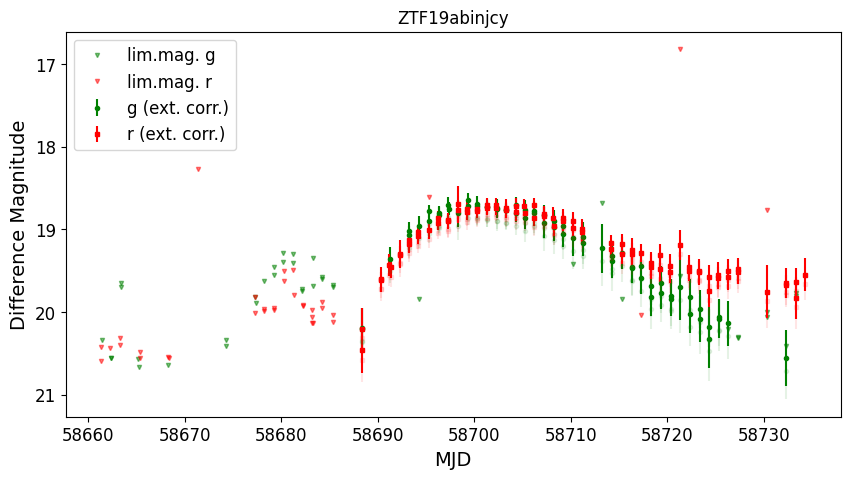

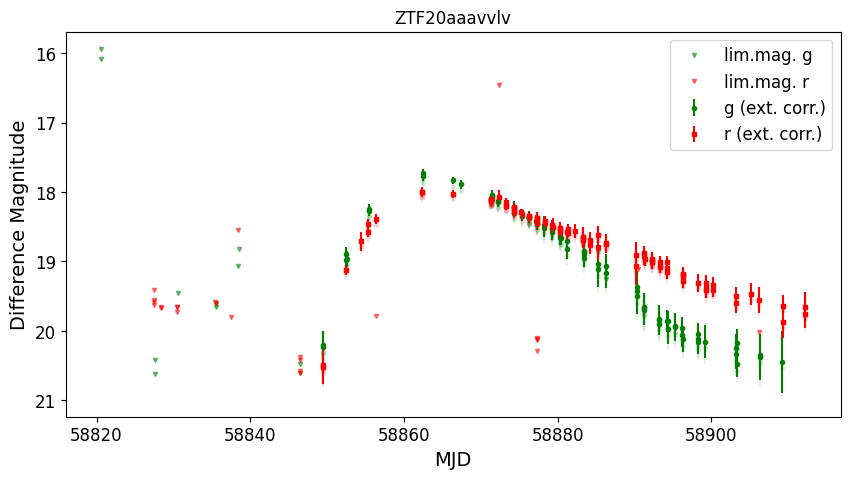

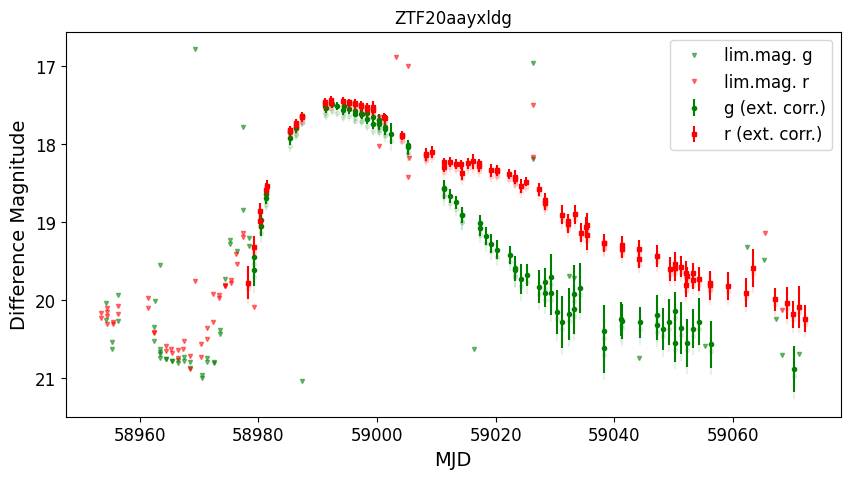

In [ ]:
# Loop through the first three unique object IDs ('oid') obtained from the 'objects' DataFrame
# and call the 'plot_diffLC_ext' function for each object.
# The function will generate and plot the light curves with extinction-corrected magnitudes for 'g' and 'r' filters.
# The resulting 'LC_g' and 'LC_r' data for each object can be used for further analysis if needed.
for oid in np.unique(objects['oid'])[:3]:
    LC_g, LC_r = plot_diffLC_ext(oid)


## Step 3. Get redshift of the objects

Note. NED might be missing some redshifts, you can also use the ones you compiled from the spreadsheet

In [ ]:
from requests.models import ReadTimeoutError
from astroquery.ipac.ned.core import RemoteServiceError

def get_redshift(oid):

    # Query 'alerce' service to get information about the object with the given 'oid'
    objects = alerce.query_objects(oid=oid, page_size=len(oid))

    # Extract the mean right ascension (ra) and declination (dec) from the queried object data
    # Create a SkyCoord object to represent the celestial coordinates (ra, dec) in the FK5 coordinate frame
    coord = coordinates.SkyCoord(ra=objects.meanra, dec=objects.meandec, unit=(u.deg, u.deg), frame='fk5')

    # Create an array to store redshift values for each coordinate
    redshifts = np.zeros(len(coord))

    # Loop through each coordinate (i: index) and query the NASA/IPAC Extragalactic Database (NED) for redshift information
    for i in range(len(coord)):

        try:
            # Query NED for objects within a small region around the current coordinate (0.01 degrees radius)
            Ned_table = Ned.query_region(coord[i], radius=0.01 * u.deg, equinox='J2000.0')
            df_ned = Ned_table.to_pandas()

            # Check if any redshift information is available for the objects in the queried region
            mask = df_ned.Redshift.notna()
            if mask.sum() > 0:
                # If redshift information is available, store the redshift with minimum separation from the queried position among the objects
                # with valid redshifts in the 'redshifts' array
                redshifts[i] = df_ned.loc[df_ned.loc[mask].Separation.idxmin()].Redshift

        except RemoteServiceError:
            redshifts[i] = 0

        print('query redshift of object #',i,', redshift=', redshifts[i])

    # Return the 'redshifts' array containing redshift values for each coordinate (object)
    return redshifts;


In [ ]:
# Define a dictionary with various parameters for the query
params = {
    "classifier": "lc_classifier",   # Specifies the type of classifier to use
    "format": "pandas",              # The desired format of the output (in this case, pandas DataFrame)
    "class_name": 'SNIa',            # The name of the class (type of astronomical object) to query for
    "probability": 0.6,              # The minimum probability threshold for the query
    "ndet": [50, 1000],              # A list representing the range of number of detections to filter by
    "order_by": 'ndet',              # The parameter by which the results will be ordered
    "order_mode": "DESC",            # The order in which the results will be sorted (DESC: descending order)
    "page_size": 100                 # The maximum number of objects to retrieve in each query page
}

# Perform a query to the 'alerce' service using the specified parameters
# The query will return objects that match the given criteria as a pandas DataFrame
objects = alerce.query_objects(**params)
objects

,oid,ndethist,ncovhist,mjdstarthist,mjdendhist,corrected,stellar,ndet,g_r_max,g_r_max_corr,...,lastmjd,deltajd,meanra,meandec,sigmara,sigmadec,class,classifier,probability,step_id_corr
0,ZTF20abvtozi,172,1515,59083.476030,59189.221250,False,False,174,-0.025095,NaN,...,59189.221250,105.745220,51.623669,33.748571,0.000054,0.000030,SNIa,lc_classifier,0.602000,corr_bulk_0.0.1
1,ZTF19acbpxwt,109,2841,58757.201331,58795.080451,False,False,104,-0.088064,0.657069,...,58795.080451,36.945556,240.986877,65.671158,0.000145,0.000040,SNIa,lc_classifier,0.630000,corr_bulk_0.0.1
2,ZTF22aaxtysg,49,1371,59790.250000,59870.250000,False,False,98,0.028530,NaN,...,59870.203889,79.918160,297.631706,53.314827,0.000054,0.000029,SNIa,lc_classifier,0.608000,1.1.6
3,ZTF20abhzgly,93,2405,59022.474155,59090.452442,True,False,93,-0.151258,-0.063594,...,59090.452442,67.978287,340.661069,33.713911,0.000108,0.000040,SNIa,lc_classifier,0.618000,corr_bulk_0.0.1
4,ZTF20acfasbq,128,752,59121.472153,59194.491146,False,False,91,0.019079,NaN,...,59194.491146,75.971400,122.253679,72.041468,0.000095,0.000030,SNIa,lc_classifier,0.616000,corr_bulk_0.0.1
5,ZTF21abjtqyq,272,5120,59400.301632,59470.161192,False,False,90,-0.106773,NaN,...,59470.161192,69.859560,265.342944,38.427445,0.000029,0.000022,SNIa,lc_classifier,0.678640,correction_1.0.6
6,ZTF20aazhtvi,272,1913,58979.318183,59057.177153,False,False,88,-0.076534,NaN,...,59057.176227,76.900278,237.181197,29.817448,0.000065,0.000029,SNIa,lc_classifier,0.606000,corr_bulk_0.0.1
7,ZTF20abupbub,86,1179,59078.351771,59144.219815,False,False,86,0.091053,NaN,...,59144.219815,65.868044,1.027003,51.663960,0.000035,0.000020,SNIa,lc_classifier,0.654000,corr_bulk_0.0.1
8,ZTF22abegjkl,109,2288,59819.500000,59902.250000,False,False,82,-0.117674,-0.084868,...,59902.165104,82.744526,18.172895,22.529068,0.000047,0.000040,SNIa,lc_classifier,0.614000,1.1.6
9,ZTF22abblogu,128,5011,59809.250000,59883.000000,False,False,82,-0.067987,NaN,...,59883.114514,73.850046,281.517449,64.165895,0.000079,0.000035,SNIa,lc_classifier,0.620000,1.1.6


In [ ]:
# Obtain redshift values for each unique object ID ('oid') in the 'objects' DataFrame
# by calling the 'get_redshift' function.
# The resulting 'redshifts' array will contain the redshift values corresponding to each object.
redshifts = get_redshift(objects['oid'])

redshifts

query redshift of object # 0 , redshift= 0.0
query redshift of object # 1 , redshift= 0.0
query redshift of object # 2 , redshift= 0.03811
query redshift of object # 3 , redshift= 0.0
query redshift of object # 4 , redshift= 0.03726
query redshift of object # 5 , redshift= 0.0
query redshift of object # 6 , redshift= 0.0
query redshift of object # 7 , redshift= 0.056473
query redshift of object # 8 , redshift= 0.0
query redshift of object # 9 , redshift= 0.091512
query redshift of object # 10 , redshift= 0.0
query redshift of object # 11 , redshift= 0.0
query redshift of object # 12 , redshift= 0.0
query redshift of object # 13 , redshift= 0.078365
query redshift of object # 14 , redshift= 0.075355
query redshift of object # 15 , redshift= 0.054195
query redshift of object # 16 , redshift= 0.070495
query redshift of object # 17 , redshift= 0.076558
query redshift of object # 18 , redshift= 0.087482
query redshift of object # 19 , redshift= 0.0
query redshift of object # 20 , redshift= 

array([0.      , 0.      , 0.03811 , 0.      , 0.03726 , 0.      ,
       0.      , 0.056473, 0.      , 0.091512, 0.      , 0.      ,
       0.      , 0.078365, 0.075355, 0.054195, 0.070495, 0.076558,
       0.087482, 0.      , 0.      , 0.      , 0.06803 , 0.3646  ,
       0.      , 0.      , 0.040531, 0.045869, 0.      , 0.      ,
       0.055531, 0.      , 0.      , 0.055158, 0.035691, 0.      ,
       0.      , 0.09196 , 0.084357, 0.044009, 0.      , 0.      ,
       0.063562, 0.      , 0.      , 0.071801, 0.122789, 0.      ,
       0.103218, 0.04196 , 0.      , 0.035788, 0.      , 0.      ,
       0.      , 0.      ])

## Step 4. Calculate the distance modulus using the maximum brightness in supernova light curve

In [ ]:
## get difference light curve data, by default g band (fid=1)

def get_magmin_ext(oid, fid=1):

    # Query 'alerce' service to get the magnitude statistics for the object with the given 'oid'
    magstats = alerce.query_magstats(oid, format='pandas')

    # Call the 'get_ext' function to obtain dust extinction values ('A') for the object with the given 'oid'
    A = get_ext(oid)[fid - 1]

    # Calculate the magnitude minimum for the specified filter (fid) and apply the dust extinction correction
    # The result is the corrected magnitude minimum for the specified filter
    magmin_ext = magstats[magstats.fid == fid].magmin - A

    return magmin_ext;

In [ ]:
# Filter objects with spectroscopic redshifts from NED
# Get the indices of the 'redshifts' array where the redshift values are not equal to zero (i.e., have spectroscopic redshifts)
ind = np.where(redshifts != 0)[0]

# Create an array 'mag_min' with the same length as the 'objects' DataFrame to store the corrected magnitude minimum for each object
mag_min = np.zeros(len(objects))

# Loop through the indices of objects with spectroscopic redshifts (ind)
for i in ind:
    # Call the 'get_magmin_ext' function to obtain the corrected magnitude minimum (using the default filter fid=1) for the object with the specified 'oid'
    # The corrected magnitude minimum is computed by considering dust extinction ('A') for the object
    mag_min[i] = get_magmin_ext(objects['oid'][i])


In [ ]:
mag_min

array([ 0.      ,  0.      , 16.95359 ,  0.      , 17.150691,  0.      ,
        0.      , 17.099625,  0.      , 18.149869,  0.      ,  0.      ,
        0.      , 18.207   , 18.310177, 17.831083, 18.154   , 18.556276,
       18.5811  ,  0.      ,  0.      ,  0.      , 17.81594 , 18.370657,
        0.      ,  0.      , 17.258528, 17.348081,  0.      ,  0.      ,
       17.399057,  0.      ,  0.      , 17.65185 , 17.14557 ,  0.      ,
        0.      , 18.699711, 18.54558 , 17.56528 ,  0.      ,  0.      ,
       17.715234,  0.      ,  0.      , 18.829223, 17.966648,  0.      ,
       18.720491, 17.530456,  0.      , 16.768177,  0.      ,  0.      ,
        0.      ,  0.      ])

## Step 5. Calculate the Hubble constant

In [ ]:
# Filter redshifts and mag_min arrays to only include objects with spectroscopic redshifts
# Select elements from 'redshifts' and 'mag_min' arrays using the indices stored in 'ind'

redshifts = redshifts[ind]
mag_min = mag_min[ind]

In [ ]:
# Function to calculate the distance modulus based on the apparent magnitude 'm' and an optional absolute magnitude 'M'.
# If 'M' is not provided, a default value of -19.3 is used for 'M'.

## Note: the absolute magnitude here is just a rough estimate, there are some uncertainties in the maximum peak magnitude of supernova type Ia

def distmod(m, M=-19.3):

    # Calculate the distance modulus using the formula:
    # distance_modulus = 10^((m - M + 5) / 5) / 1e6
    # where 'm' is the apparent magnitude, 'M' is the absolute magnitude, and '1e6' is used to convert from parsecs to megaparsecs (Mpc).
    # The distance modulus represents the difference between the true distance (in parsecs) and the apparent distance (as observed from Earth).
    # It is commonly used in astronomy to estimate distances to celestial objects based on their observed magnitudes.

    return 10**((m - M + 5) / 5.) / 1e6;  # Return the calculated distance modulus in megaparsecs (Mpc).


Text(0, 0.5, 'Velocity (km/s)')

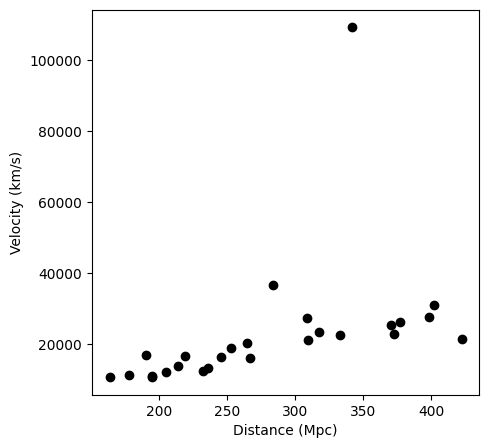

In [ ]:
# Calculate the distance modulus for the 'mag_min' array using the 'distmod' function
dist = distmod(mag_min)

# Create a new figure with a specific size
plt.figure(figsize=(5, 5))

# Plot the data points with distance (Mpc) on the x-axis and velocity (km/s) on the y-axis
plt.plot(dist, redshifts * c / 1e3, 'ko')

# Label the x-axis as 'Distance (Mpc)'
plt.xlabel('Distance (Mpc)')

# Label the y-axis as 'Velocity (km/s)'
plt.ylabel('Velocity (km/s)')

In [ ]:
## sometimes NED redshifts might be incorrect (e.g., matched to a different object), we might need to remove some outliers

# Filter 'mag_min' array and 'redshifts' array to only include data points with redshift values less than 0.1
mag_min = mag_min[np.where(redshifts<0.1)]
redshifts = redshifts[np.where(redshifts<0.1)]

H0 =    67 km/s/Mpc


Text(0, 0.5, 'Velocity (km/s)')

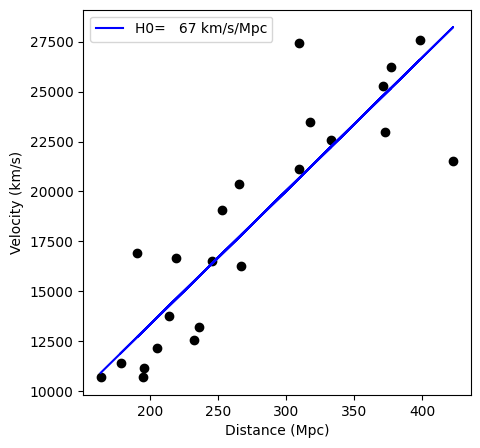

In [ ]:
# Calculate the distance modulus for the 'mag_min' array using the 'distmod' function
dist = distmod(mag_min)

# Create a new figure with a specific size
plt.figure(figsize=(5, 5))

# Plot the data points with distance (Mpc) on the x-axis and velocity (km/s) on the y-axis
plt.plot(dist, redshifts * c / 1e3, 'ko')

# Define a function 'func' that represents the linear relationship between distance and velocity
def func(x, H0):
    # The function takes a distance value 'x' and a parameter 'H0' (Hubble constant)
    # It returns the velocity (km/s) calculated as x*H0
    return x * H0;

# Use the 'curve_fit' function from 'scipy.optimize' to fit the 'func' function to the data points
# The fitting finds the best value for 'H0' that fits the data
popt, pcov = curve_fit(func, dist, redshifts * c / 1e3)

# Print the optimal value of 'H0' obtained from the curve fitting
print('H0 = %5.0f km/s/Mpc' % tuple(popt))

# Plot the fitted function on the same plot using the optimal value of 'H0'
plt.plot(dist, func(dist, *popt), 'b-', label='H0=%5.0f km/s/Mpc' % tuple(popt))

# Add a legend to the plot (assuming that there is a legend defined somewhere else in the code)
plt.legend()

# Label the x-axis as 'Distance (Mpc)'
plt.xlabel('Distance (Mpc)')

# Label the y-axis as 'Velocity (km/s)'
plt.ylabel('Velocity (km/s)')
